<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - CARD4L backscatter computation for 20 MGRS tiles on CreoDIAS
## On-demand CARD4L processing of Sentinel-1 data for a large area

This notebook focuses on the use case where the user simply wants to generate backscatter data for a given area and temporal extent.

In this case, we compute 1 month of data over 1 MGRS tile, which in total amounts to generating backscatter data for 41 Sentinel-1 observations over this area. This should cover the requirement to generate 20 MGRS tiles worth of data.

The CreoDIAS cluster size is currently limited to support only 4 executors in a batch job, so running larger jobs is possible, but requires longer waiting times. We do however focus on the scalability of the solution.



In [1]:
from eo_utils import *

## Step 1 -  Area of Interest selection
### Run the next cell, click on the rectangle button and then draw the area over the map like in the following example image
<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/selection_bbox.jpg"
     alt="rectangle_selection"
     style="float: left; margin-right: 10px;" />

In [2]:
center = [46.49, 11.35]
zoom = 12

eoMap = openeoMap(center,zoom)
addS2Tiles(eoMap)
eoMap.map

Map(center=[46.49, 11.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

Get the bounding box from the previous map.

In [3]:
bbox = eoMap.getBbox()
print('west',bbox[0],'\neast',bbox[2],'\nsouth',bbox[1],'\nnorth',bbox[3])

west 4.507619 
east 5.760225 
south 48.704617 
north 49.552894


In [4]:
bbox

(4.507619, 48.704617, 5.760225, 49.552894)

<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/Sentinel_1.jpg"
     alt="Sentinel-1"
     style="float: left; margin-right: 10px; width:100px" />
## openEO graph creation for CARD4L ARD Sentinel-1 processed with CreoDIAS

1. Open the connection with openEO back-end. 

In [5]:
vito_backend_url = "openeo.creo.vito.be"
vito_conn = openeo.connect(vito_backend_url)

In [6]:
vito_conn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.creo.vito.be/openeo/1.0/' with BearerAuth>

2. Define range of interest in time for Sentinel-1

In [7]:
collection      = 'SENTINEL1_GRD'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2021-01-06", "2021-02-06"]
bands           = ["VV","VH"]

s1 = vito_conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

3. Apply the SAR processing.

In [8]:
s1bs = s1.sar_backscatter(coefficient="sigma0-ellipsoid",options={"implementation_version":"2","tile_size":256, "otb_memory":256})#,elevation_model="off"

In [15]:
job_options={
    "driver-memory": "2G",
    "driver-memoryOverhead": "1G",
    "driver-cores": "1",
    "executor-memory": "1G",
    "executor-memoryOverhead": "4G",
    "executor-cores": "1",    
    "max-executors": "6"
}

In [16]:
%%time
s1bs.max_time().execute_batch(out_format="GTiff",title="MultiTile",description="Generate one MGRS tile with Sentinel-1 backscatter",job_options=job_options)

0:00:00 Job 'b3f9bb32-258c-4e00-bead-b6ca13727463': send 'start'
0:00:11 Job 'b3f9bb32-258c-4e00-bead-b6ca13727463': created (progress N/A)
0:00:17 Job 'b3f9bb32-258c-4e00-bead-b6ca13727463': created (progress N/A)
0:00:23 Job 'b3f9bb32-258c-4e00-bead-b6ca13727463': created (progress N/A)
0:00:31 Job 'b3f9bb32-258c-4e00-bead-b6ca13727463': created (progress N/A)
0:00:42 Job 'b3f9bb32-258c-4e00-bead-b6ca13727463': created (progress N/A)
0:00:54 Job 'b3f9bb32-258c-4e00-bead-b6ca13727463': created (progress N/A)
0:01:10 Job 'b3f9bb32-258c-4e00-bead-b6ca13727463': created (progress N/A)
0:01:29 Job 'b3f9bb32-258c-4e00-bead-b6ca13727463': running (progress N/A)
0:01:54 Job 'b3f9bb32-258c-4e00-bead-b6ca13727463': running (progress N/A)
0:02:24 Job 'b3f9bb32-258c-4e00-bead-b6ca13727463': running (progress N/A)
0:03:02 Job 'b3f9bb32-258c-4e00-bead-b6ca13727463': running (progress N/A)
0:03:49 Job 'b3f9bb32-258c-4e00-bead-b6ca13727463': running (progress N/A)
0:04:47 Job 'b3f9bb32-258c-4e00-bea

<RESTJob job_id='b3f9bb32-258c-4e00-bead-b6ca13727463'>

In [17]:
j=vito_conn.job("b3f9bb32-258c-4e00-bead-b6ca13727463")
j

<RESTJob job_id='b3f9bb32-258c-4e00-bead-b6ca13727463'>

In [19]:
j.get_results()

<JobResults for job 'b3f9bb32-258c-4e00-bead-b6ca13727463'>

In [18]:
j.download_results()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated method download_results. (Instead use :py:meth:`RESTJob.get_results` and the more flexible download functionality of :py:class:`JobResults`) -- Deprecated since version 0.4.10.
  """Entry point for launching an IPython kernel.
/data/users/Public/driesj/openeo/openeo-python-client/openeo/rest/job.py:104: DeprecationWarning: Call to deprecated method get_result. (Use :py:meth:`RESTJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/data/users/Public/driesj/openeo/openeo-python-client/openeo/rest/job.py:108: DeprecationWarning: Call to deprecated class _Result. (Use :py:class:`JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


{PosixPath('/data/users/Public/driesj/openeo/SRR1_notebooks/openEO.tif'): {'eo:bands': [{'name': 'VV'},
   {'name': 'VH'}],
  'file:nodata': ['nan'],
  'href': 'https://openeo.creo.vito.be/openeo/1.0/jobs/b3f9bb32-258c-4e00-bead-b6ca13727463/results/openEO.tif',
  'roles': ['data'],
  'title': 'openEO.tif',
  'type': 'image/tiff; application=geotiff'}}

In [20]:
!gdalinfo openEO.tif

ERROR 5: openEO.tif: GDALDataset::GetRasterBand(3) - Illegal band #

Driver: GTiff/GeoTIFF
Files: openEO.tif
Size is 8872, 9688
Coordinate System is:
PROJCS["WGS 84 / UTM zone 31N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",3],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32631"]]
Origin = (610920.000000000000000,5492590.000000000000000)
Pixel Size = (10.000000000

Screenshot of this result:

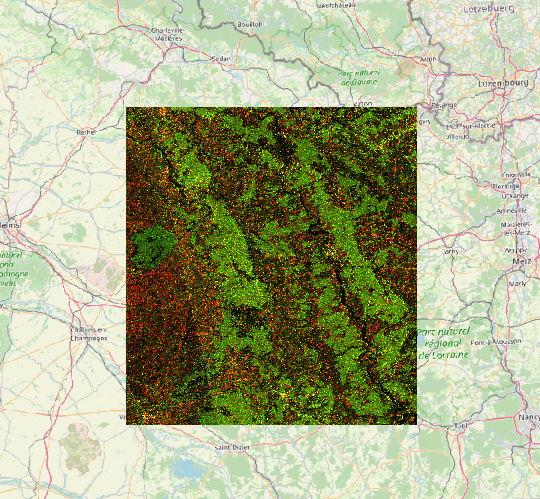

# Performance metrics

Spark and Grafana dashboards were used to capture some metrics while processing the 41 backscatter products.
The screenshots contain all details and serve as evidence of the job that was performed.

To summarize:
* Median duration per product: 6 minutes
* Max duration per product: 10 minutes
* Total cpu time: 4.7 hours

The task duration distribution is now rather constant, which also allows good scalability. So adding executors would reduce the total wall time. As an upper bound, having 41 executors would have finished this task in 10 minutes. (The time of the longest running task.)

We do require a total of 5GB, which is more than the 3GB we require for normal jobs. It remains to be seen if this can be reduced, by modifying GDAL and Orfeo parameters. On the other hand, if we work with VM's of 16GB ram, we can fit in 3 executors per VM in this way.


## Task summary

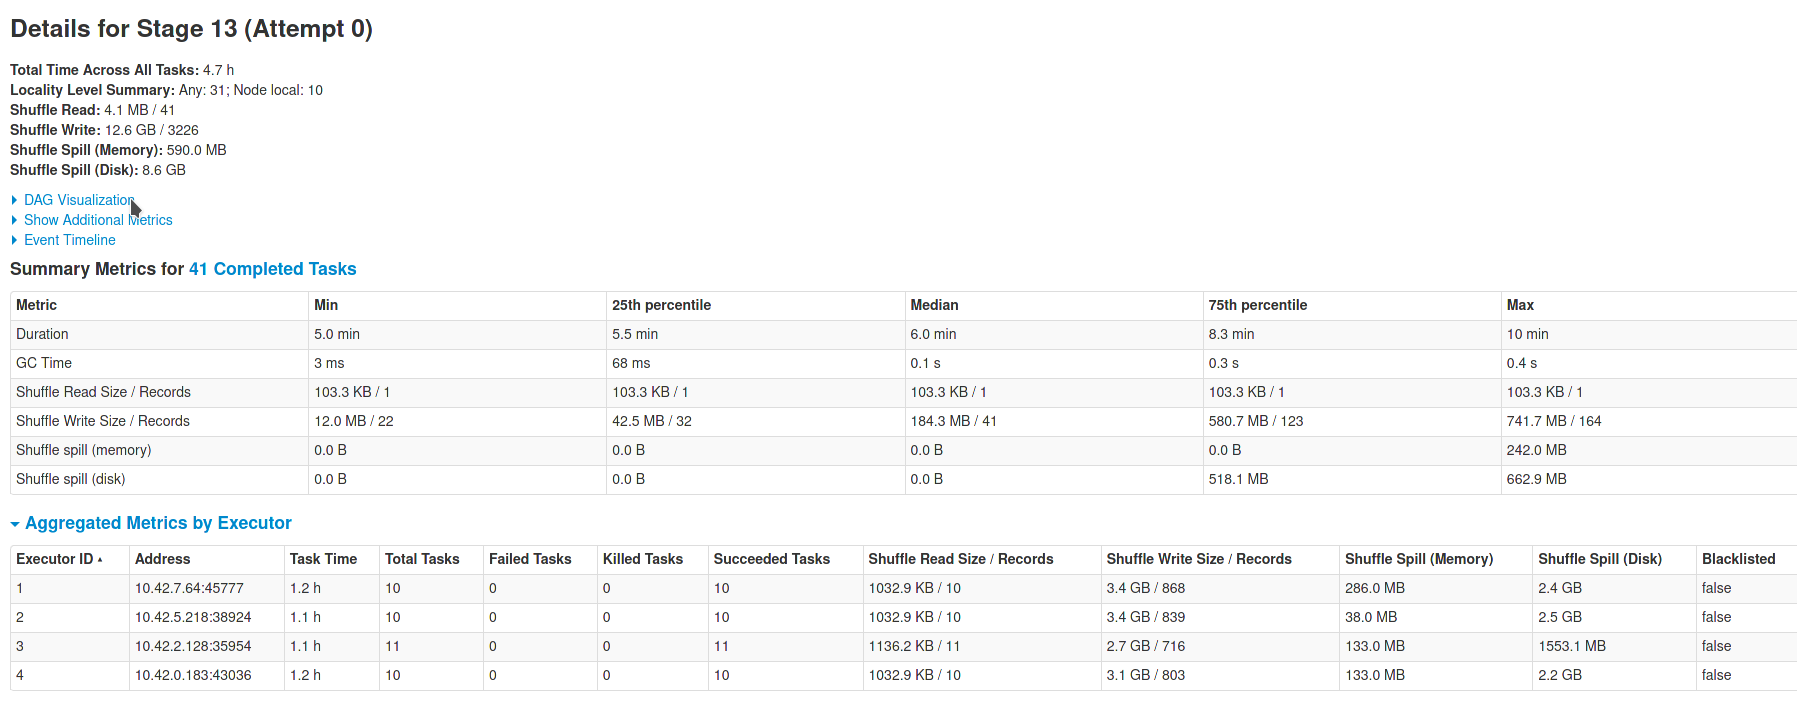

## Individual Tasks

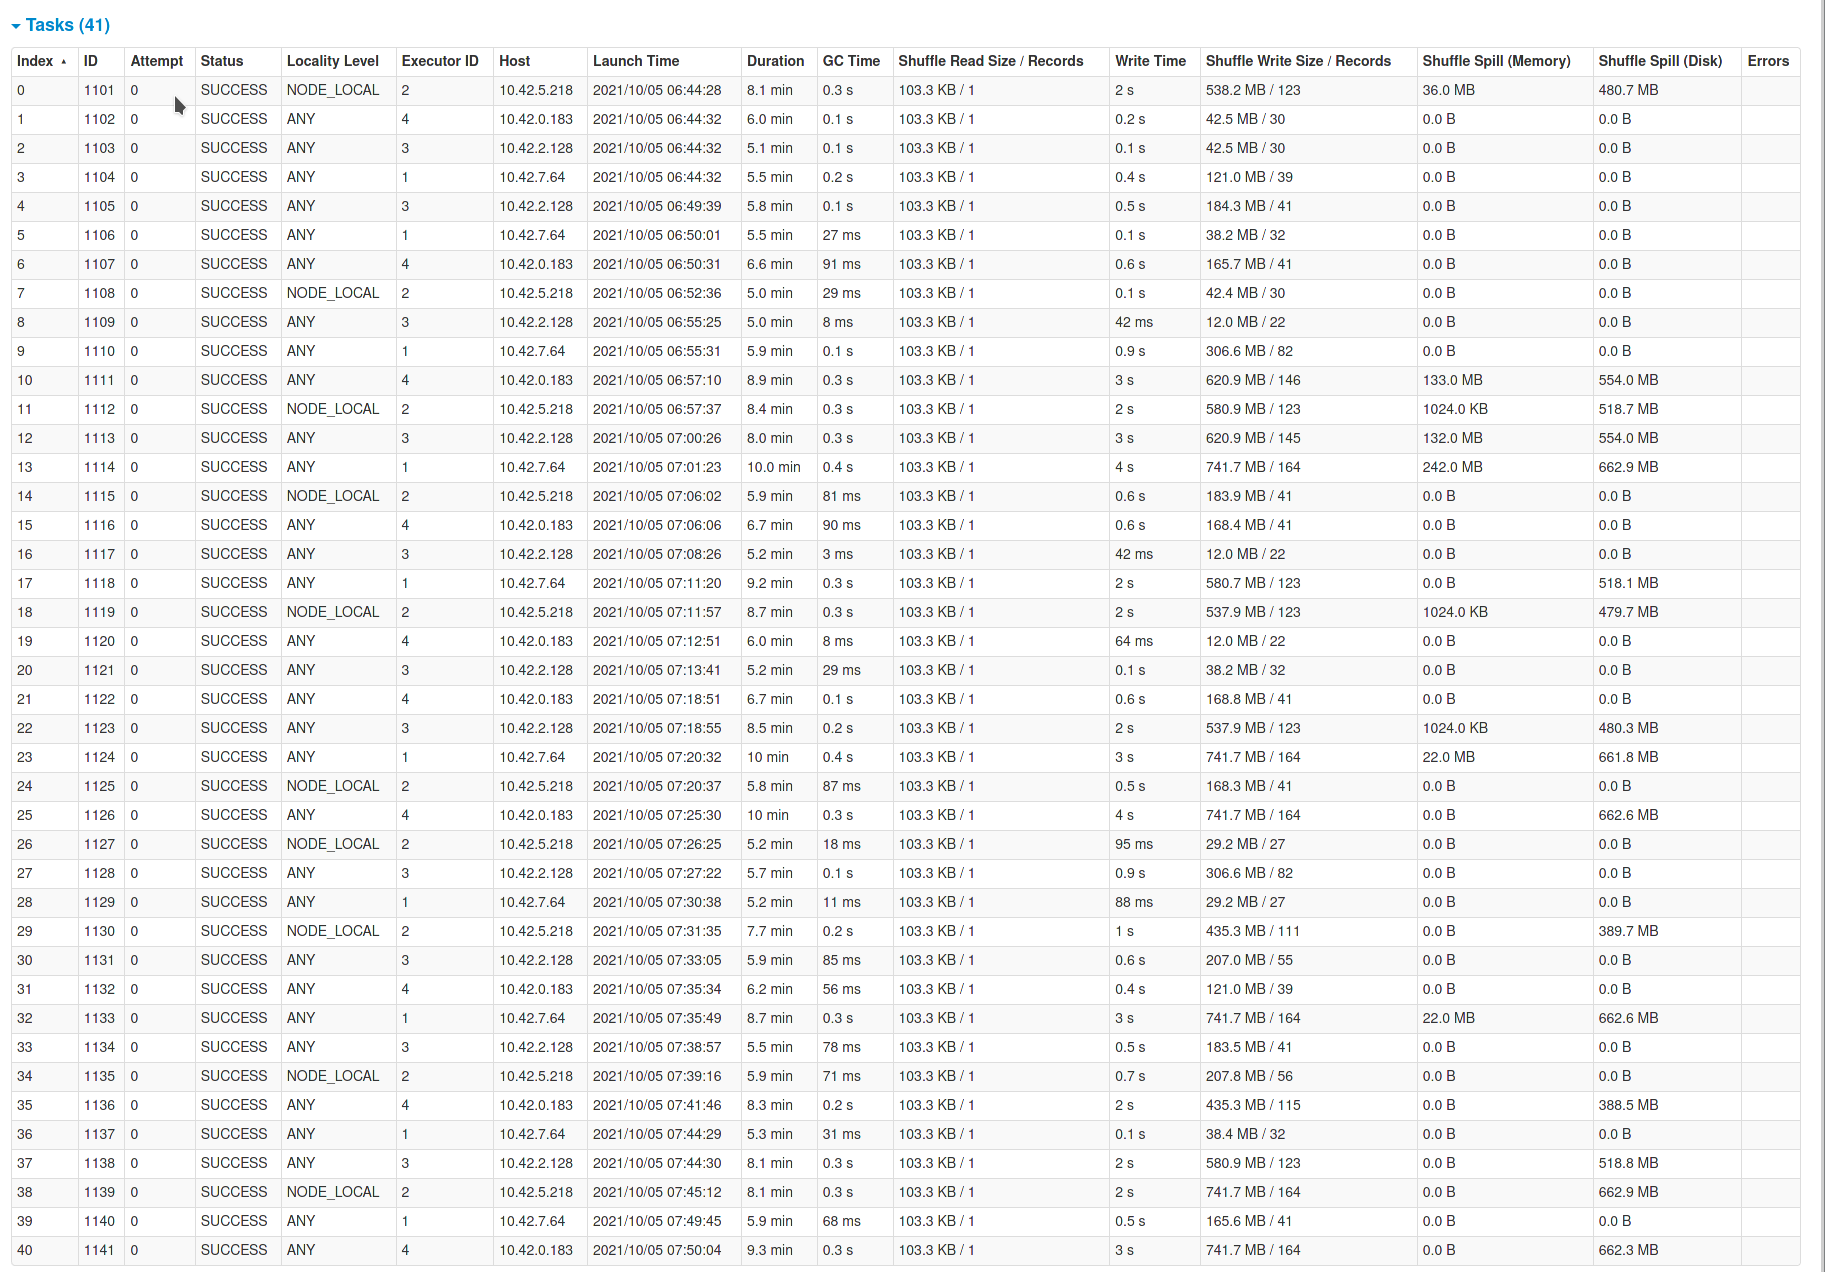


## Memory usage

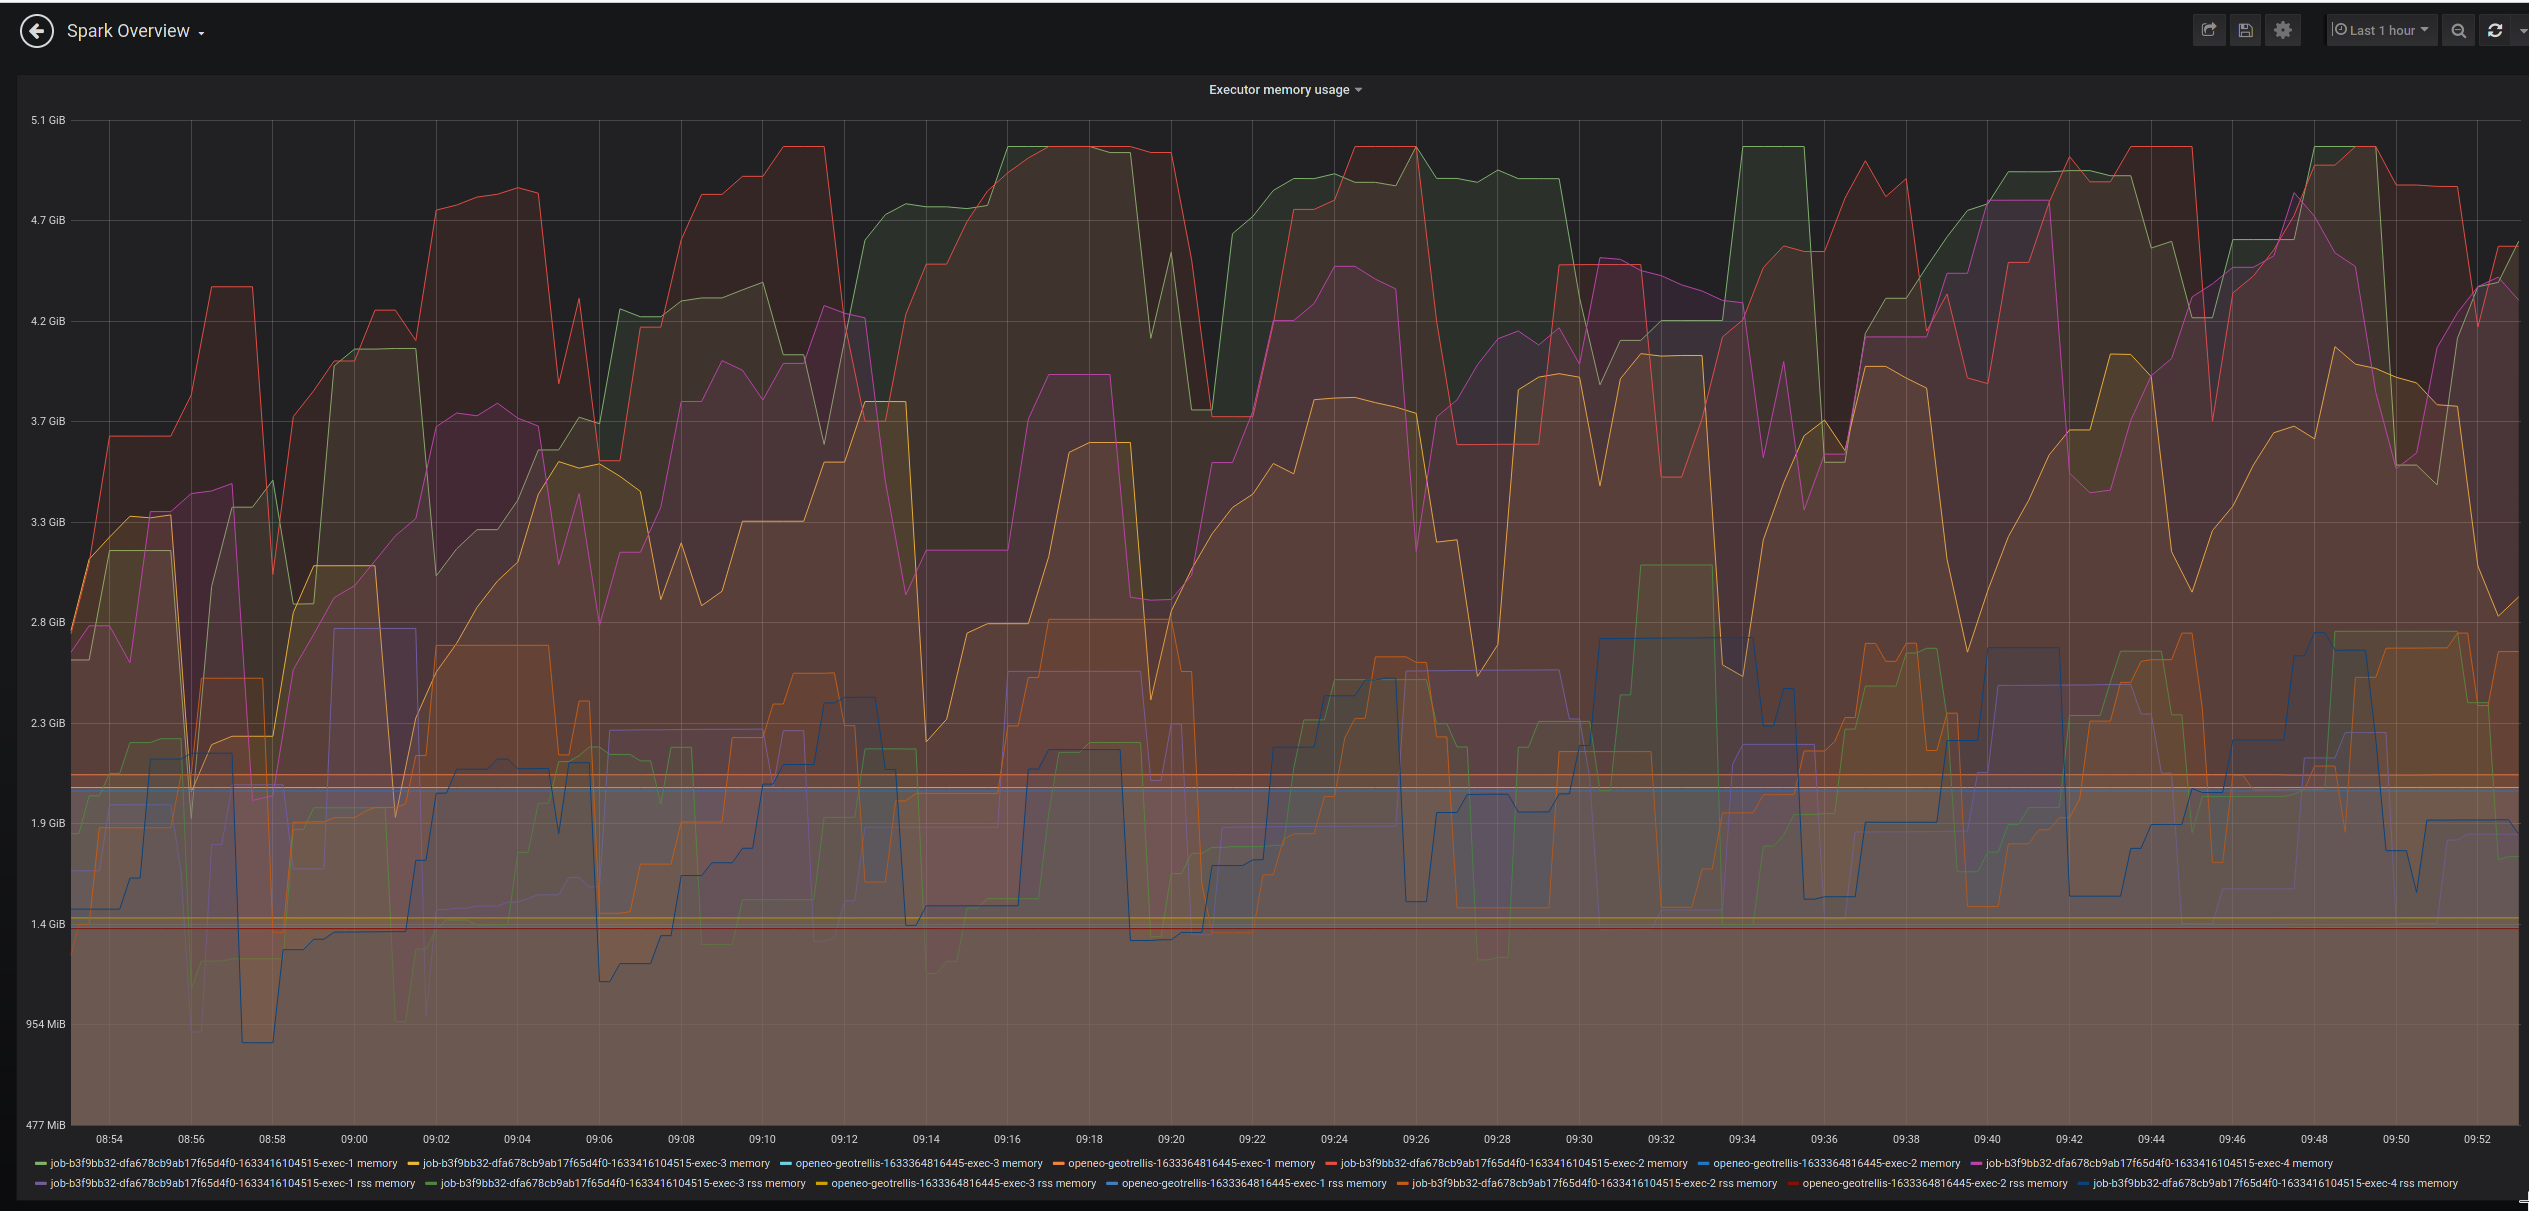

The downloaded data can be opened, using a desktop tool like QGis is the easiest option.

The foreseen way of interacting with it is to use openEO to further process the dataset into a more manageable result.